In [2]:
import pandas as pd
import numpy as np
import os
import sys
!{sys.executable} -m pip install nump
import librosa
import librosa.display
import struct
import numpy as np 
import struct
class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)
#from helpers.wavfilehelper import WavFileHelper

def extract_features(file_name, max_pad=174, n=40):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n)
        # padding
        pad_width = max_pad - mfccs.shape[1]
        mfccs_pad = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccs, mfccs_pad, mfccsscaled

ERROR: Could not find a version that satisfies the requirement nump (from versions: none)
ERROR: No matching distribution found for nump


In [3]:
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [80]:
# extract the audio files property and standarized the properties of the audio files then extract features
wavfilehelper = WavFileHelper()
audio_data = []
audio_feature = []
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath('UrbanSound8K/audio/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    # extract the property
    proper = wavfilehelper.read_file_properties(file_name)
    audio_data.append(proper)
    # extract the features
    label = row['classID']
    mfccs, mfccs_pad, mfccsscaled = extract_features(file_name)
    audio_feature.append([mfccs, mfccs_pad, mfccsscaled, label])

# Convert into a Panda dataframe
audio_property = pd.DataFrame(audio_data, columns=['num_channels','sample_rate','bit_depth'])
audio_feature = pd.DataFrame(audio_feature, columns=['mfccs', 'mfccs_pad','feature','class_label'])


In [4]:
# save the variables
#audio_property.to_pickle("audio_property.pkl")
#audio_feature.to_pickle("audio_feature.pkl")

# read the variables
audio_property = pd.read_pickle("audio_property.pkl")
audio_feature = pd.read_pickle("audio_feature.pkl")

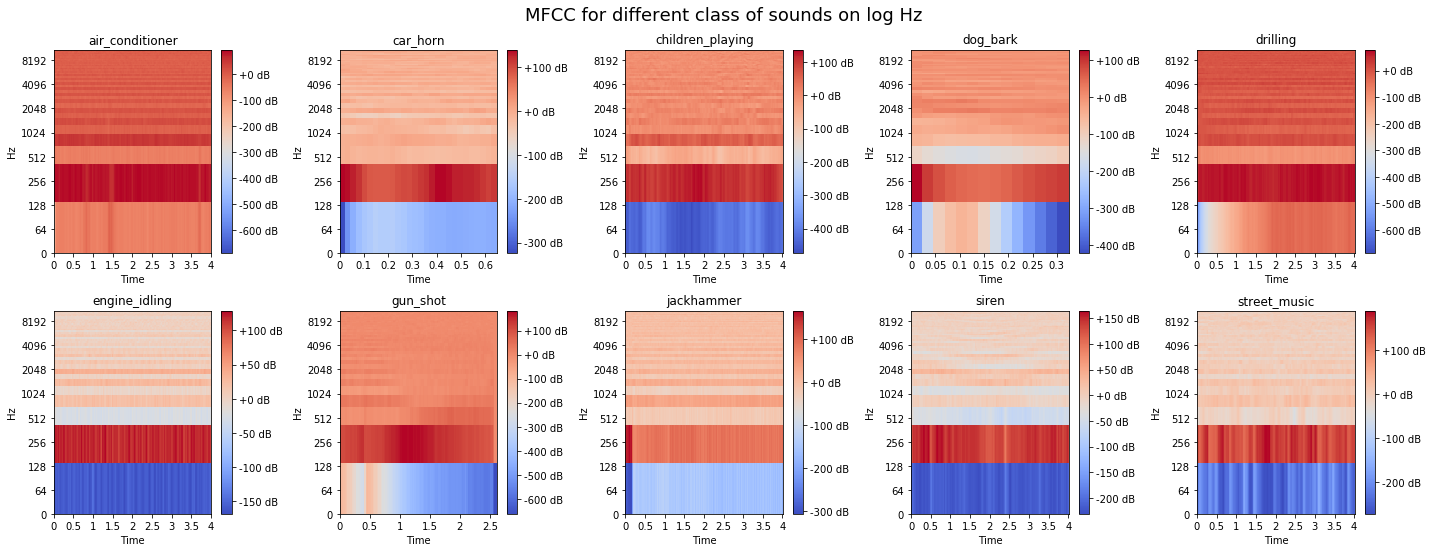

In [6]:
# Draw the MFCC Spectrogram for each of the class of the sound data, comparing the graph
# https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
import matplotlib.pyplot as plt

# choose a sample of sound from each class
sound_class_dic = metadata.groupby(['class', 'classID']).size()
sound_sample = []
for c in range(10):
    for index, row in audio_feature.iterrows():
        if c == row['class_label']:
            sound_sample.append(row)
            break

# Draw the MFCC Spectrogram for each class
fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
plt.title('MFCC for different class of sounds on log Hz', y = 1.05, fontsize = 18)
plt.axis('off')
for i in range(10):
    fig.add_subplot(2,5,i+1)
    plt.title(f'{sound_class_dic.index[i][0]}')
    librosa.display.specshow(sound_sample[i]['mfccs'], x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

In [7]:
# encode the categorical text data
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
# ??? what suppose to be the input of CNN
X = np.array(audio_feature.feature.tolist())
y = np.array(audio_feature.class_label.tolist())

X_2D = np.array(audio_feature.mfccs_pad.tolist())
y_2D = np.array(audio_feature.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
yy_2D = to_categorical(le.fit_transform(y_2D)) 

Using TensorFlow backend.


In [8]:
# prepare the input data
# split the data into train and test data sets
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
x_train_2D, x_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, yy_2D, test_size=0.2, random_state = 42)

In [9]:
# SVM
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [9]:
# search the hyperparameter space to find the best model
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5],'C': [1, 10 ,20,30,40,50]}]
#                    , {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
searchpara = GridSearchCV(svm.SVC(), tuned_parameters)
searchpara.fit(x_train, y_train)
searchpara.best_params_

{'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}

In [10]:
# construct the model by the best hyperparameters found above
SVM = svm.SVC(C=50.0, gamma=0.0001)
# train the model
SVM.fit(x_train,y_train)
y_pred = SVM.predict(x_test)
train_accu =  SVM.score(x_train, y_train)
test_accu = SVM.score(x_test, y_test)
print('Training Accuracy:', train_accu)
print('Test Accuracy:', test_accu)

Training Accuracy: 0.9942734430923408
Test Accuracy: 0.9170005724098454


Confusion matrix, without normalization


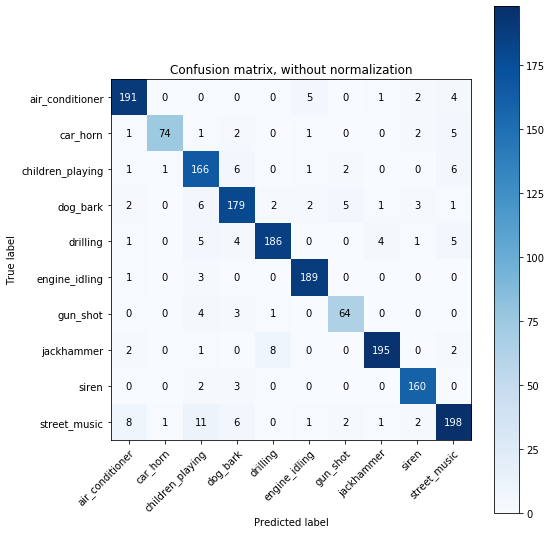

In [15]:
# draw confusion matrix
# new ver: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# old ver: https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          percentage = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = metadata.groupby(['class', 'classID'], as_index = False).sum()['class']
plot_confusion_matrix(y_test, y_pred, classes=class_names, cmap=plt.cm.Blues, normalize= False)
plt.show()

In [19]:
# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train_2D = x_train_2D.reshape(x_train_2D.shape[0], num_rows, num_columns, num_channels)
x_test_2D = x_test_2D.reshape(x_test_2D.shape[0], num_rows, num_columns, num_channels)

num_labels = yy_2D.shape[1]
filter_size = 2

# construct model
CNN = Sequential()
CNN.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
CNN.add(MaxPooling2D(pool_size=2))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
CNN.add(MaxPooling2D(pool_size=2))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
CNN.add(MaxPooling2D(pool_size=2))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
CNN.add(MaxPooling2D(pool_size=2))
CNN.add(Dropout(0.2))
CNN.add(GlobalAveragePooling2D())

CNN.add(Dense(num_labels, activation='softmax'))

# Compile the model
CNN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
CNN.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 41, 64)       

In [ ]:
# train the model
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

CNN.fit(x_train_2D, y_train_2D, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test_2D, y_test_2D), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train_2D, y_train_2D, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test_2D, y_test_2D, verbose=0)
print("Testing Accuracy: ", score[1])

In [ ]:
# draw confusion matrix
y_pred_2D = CNN.predict(x_test_2D)
plot_confusion_matrix(y_test_2D, y_pred_2D, classes=class_names, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# compare the accuracy between different models


# draw the confusion matrix of the best model
